In [1]:
from sbibm.metrics import c2st

import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az


from torchdyn.core import NeuralODE, DEFunc
from functools import partial
from dataclasses import asdict
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.functional import mse_loss

torch.set_printoptions(linewidth=1000) #nice prints

#own imports
from configurations.config_rcd_BIG import *
from utils import *

In [2]:
# Load the calibration data
url = "http://www.stats.ox.ac.uk/~nicholls/BayesMethods/SHRCC2013.txt"
rcc_dat = pd.read_csv(url, sep=",", header=0)
rcc_dat = rcc_dat.iloc[::-1] #reverse order

print(rcc_dat.info())
print(rcc_dat.head())  

CAL_BP = rcc_dat['CAL BP']
X14C_age = rcc_dat['14C age']
Error = rcc_dat['Error']

Earliest = 1000
Latest = 1

y_BP = np.arange(Latest, Earliest + 1)

# Perform spline interpolation for mu and err
mu_spline = UnivariateSpline(CAL_BP, X14C_age, s=0)
mu = mu_spline(y_BP)

err_spline = UnivariateSpline(CAL_BP, Error, s=0)
err = err_spline(y_BP)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5141 entries, 5140 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CAL BP     5141 non-null   int64  
 1   14C age    5141 non-null   int64  
 2   Error      5141 non-null   int64  
 3   Delta 14C  5141 non-null   float64
 4   Sigma      5141 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 200.9 KB
None
      CAL BP  14C age  Error  Delta 14C  Sigma
5140       0      161     13      -19.8    1.6
5139       5      153      8      -18.3    1.0
5138      10      150     10      -17.3    1.2
5137      15      156      9      -17.5    1.1
5136      20      150     10      -16.1    1.2


In [3]:
# Radiocarbon dates
y = np.array([580,600,537,670,646,630,660])
nd = len(y)  # Number of dates
d = np.array([47,50,44,47,47,35,46]) # Measurement errors
s = np.array([1,2,3,4,5,5,6]) # Layers, not used here
nm = np.array(["NZ 7758","NZ 7761","NZ 7757","NZ 7756","NZ 7755","WK 2589","NZ 7771"]) # Laboratory date identifiers

# Conservative bounds on the settlement dates
L = 500  # Lower bound
U = 1000  # Upper bound

In [4]:
# Log likelihood for theta
def llk(theta):
    sig = np.sqrt(d**2 + err[theta]**2)
    log_likelihood = np.sum(norm.logpdf(y, loc=mu[theta], scale=sig))
    return log_likelihood

# Log prior for psi
def lpr(psi):
    S = psi[1] - psi[0]
    log_prior = -nd * np.log(S) - np.log(U - L - S)
    return log_prior

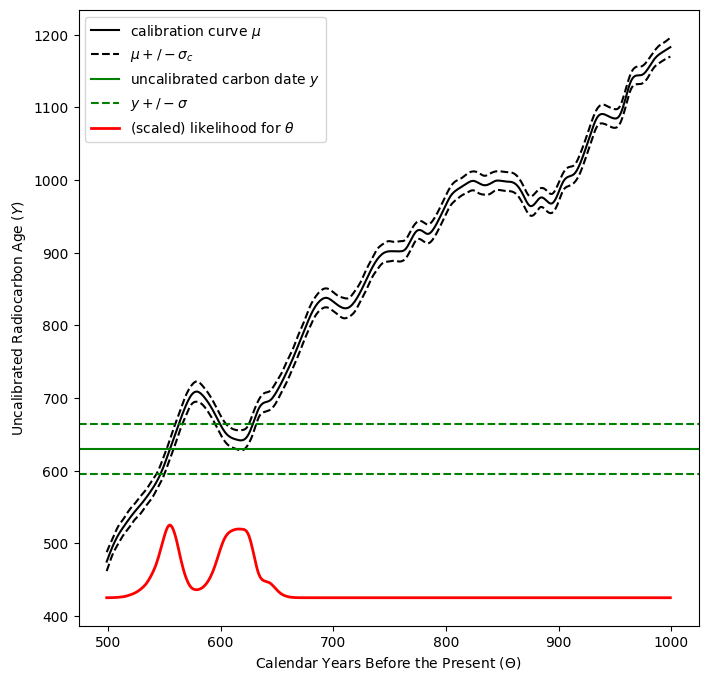

In [5]:
# Illustrating calibration function and likelihood
x = np.arange(L-1, U)

plt.figure(figsize=(8, 8))
plt.plot(x, mu[x], label=r'calibration curve $\mu$', color='black')
plt.plot(x, mu[x] + err[x], linestyle='--', color='black', label=r'$\mu +/- \sigma_c$')
plt.plot(x, mu[x] - err[x], linestyle='--', color='black')

# Plot for the i-th data point
i = 5  
plt.axhline(y=y[i], color='green', label=r'uncalibrated carbon date $y$')
plt.axhline(y=y[i] - d[i], linestyle='--', color='green', label=r'$y +/- \sigma$')
plt.axhline(y=y[i] + d[i], linestyle='--', color='green')

# Calculate the scaled likelihood for theta
z = norm.pdf(y[i], loc=mu[x], scale=np.sqrt(d[i]**2 + err[x]**2))
z = (z - np.min(z)) / np.abs(np.max(z))
z_scaled = plt.gca().get_ylim()[0] + 100 * z

plt.plot(x, z_scaled, color='red', linewidth=2, label=r'(scaled) likelihood for $\theta$')
plt.legend(loc='upper left')
plt.xlabel(r'Calendar Years Before the Present ($\Theta$)')
plt.ylabel('Uncalibrated Radiocarbon Age ($Y$)')

plt.show()


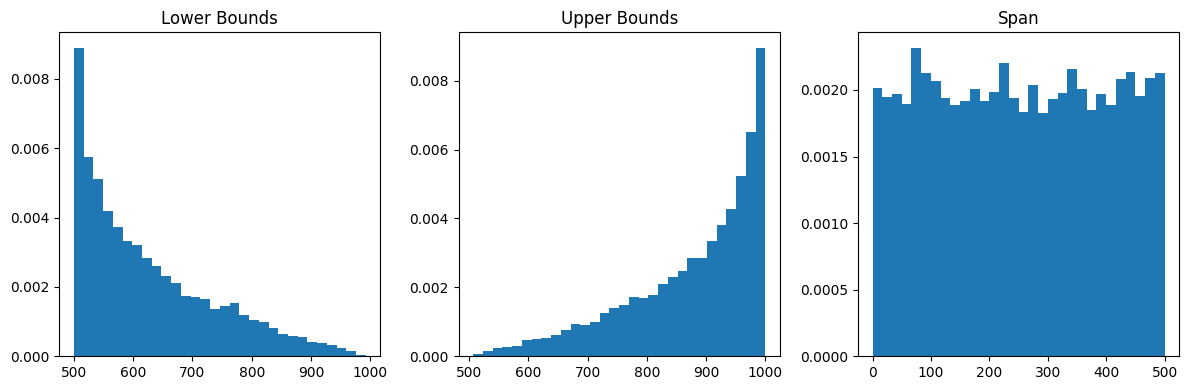

In [6]:
K = 10000
span = np.random.uniform(low=0, high=U-L, size=K)
lower = np.zeros(K)
upper = np.zeros(K)
for k in range(K):
    lower[k] = np.random.uniform(low=L, high=U-span[k])
    upper[k] = lower[k] + span[k]

# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(lower, bins=30, density=True)
axs[0].set_title('Lower Bounds')
axs[1].hist(upper, bins=30, density=True)
axs[1].set_title('Upper Bounds')
axs[2].hist(span, bins=30, density=True)
axs[2].set_title('Span')

plt.tight_layout()
plt.show()


# MCMC

In [7]:
# MCMC sampler function
def rcd_mcmc(nd, L, U, T, SubS, w=1.1, scale_move=True):
    # Initialize the start state for the MCMC
    theta = np.sort(np.random.uniform(low=L, high=U, size=nd))
    psi = np.array([(L + theta[0]) / 2, (theta[-1] + U) / 2])
    llo = llk(theta.astype(int) - 1)#-1 for correct python indexing
    lpo = lpr(psi)

    # Prepare output matrix
    OP = np.full((T // SubS, 1 + 2 + nd + 2), np.nan)

    # Run the MCMC for T steps
    for t in tqdm(range(T)):
        # Go through each of the parameters in turn
        for i in range(nd):
            thetap = np.copy(theta)
            # The proposal is uniform in allowed range
            thetap[i] = np.random.uniform(low=psi[0], high=psi[1])

            lln = llk(thetap.astype(int) - 1)  # no change to prior
            logMHR = lln - llo
            if np.log(np.random.uniform()) < logMHR:
                theta = thetap
                llo = lln

        # Update psi[0]
        psip = np.copy(psi)
        psip[0] = np.random.uniform(low=L, high=np.min(theta))
        lpn = lpr(psip)
        logMHR = lpn - lpo
        if np.log(np.random.uniform()) < logMHR:
            psi = psip
            lpo = lpn

        # Update psi[2]
        psip = np.copy(psi)
        psip[1] = np.random.uniform(low=np.max(theta), high=U)
        lpn = lpr(psip)
        logMHR = lpn - lpo
        if np.log(np.random.uniform()) < logMHR:
            psi = psip
            lpo = lpn

        # Scale move step
        if scale_move:
            delta = np.random.uniform(low=w, high=1/w)
            m = np.mean(np.concatenate((psi, theta)))
            psip = m + (psi - m) * delta
            thetap = m + (theta - m) * delta

            if (psip[0] > L) and (psip[1] < U):
                lpn = lpr(psip)
                lln = llk(thetap.astype(int) - 1)
                lqq = (nd - 1) * np.log(delta)
                logMHR = lln - llo + lpn - lpo + lqq
                if np.log(np.random.uniform()) < logMHR:
                    psi = psip
                    theta = thetap
                    lpo = lpn
                    llo = lln

        # Subsample - take a sample every SubS steps - store it in Output
        if t % SubS == 0:
            span = np.diff(psi)
            OP[t // SubS, :] = np.concatenate((span, psi, theta, np.atleast_1d(llo), np.atleast_1d(lpo)))

    return OP

In [8]:
T=1000000
SubS=100
Nsamp=T//SubS

# # Run the MCMC for the shrinkage model
# mcmc_shrink =rcd_mcmc(nd,L,U,T,SubS, w=0.25,scale_move=True)

mcmc_shrink = np.load("models/RCD_MCMC.npy") #or load from previous run to save time

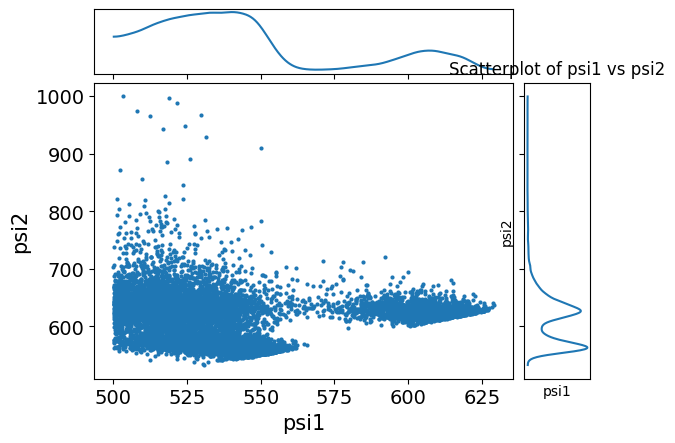

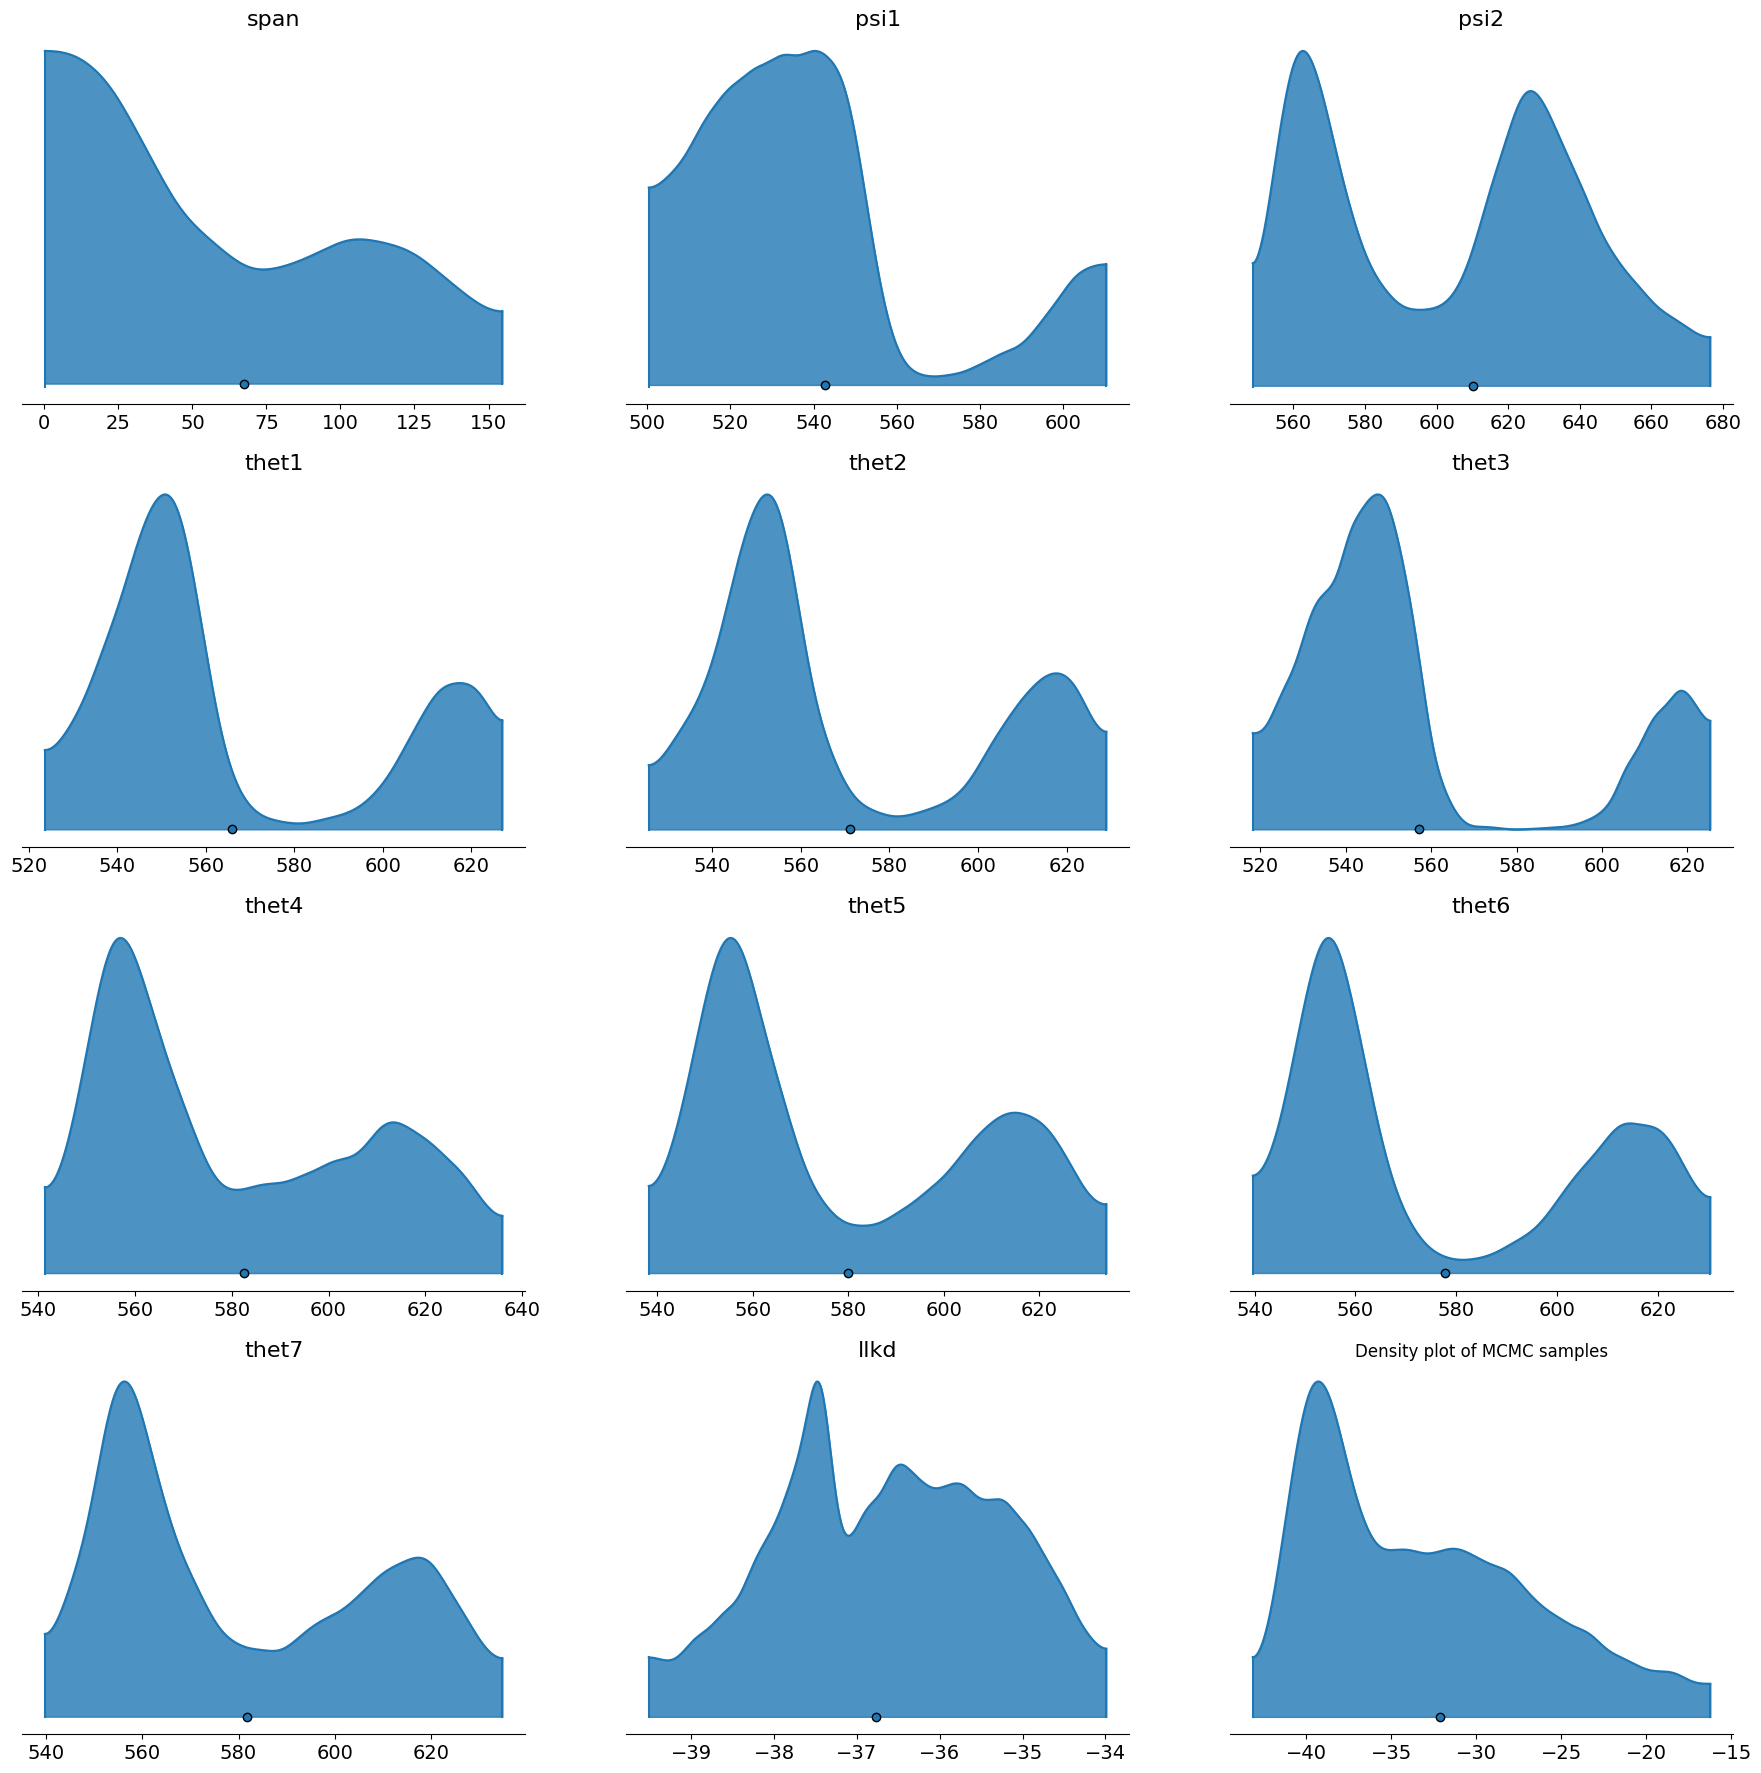

Effective Sample Sizes:
<xarray.Dataset> Size: 96B
Dimensions:  ()
Data variables:
    span     float64 8B 6.392e+03
    psi1     float64 8B 4.123e+03
    psi2     float64 8B 4.257e+03
    thet1    float64 8B 4.212e+03
    thet2    float64 8B 4.399e+03
    thet3    float64 8B 4.355e+03
    thet4    float64 8B 3.415e+03
    thet5    float64 8B 3.686e+03
    thet6    float64 8B 3.751e+03
    thet7    float64 8B 3.574e+03
    llkd     float64 8B 6.189e+03
    lpri     float64 8B 6.391e+03


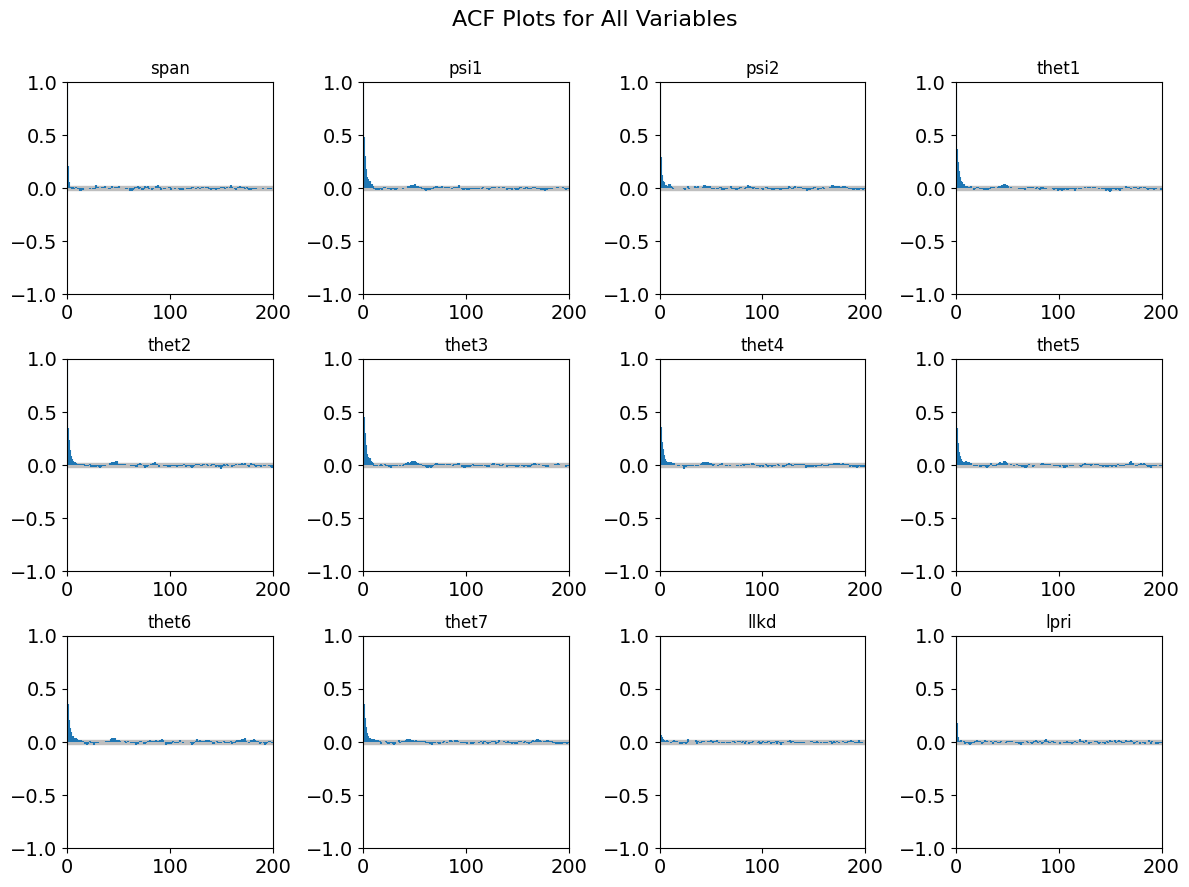

In [9]:
colnames_shrink = ['span', 'psi1', 'psi2'] + [f'thet{i+1}' for i in range(nd)] + ['llkd', 'lpri']

# Convert the output to a format suitable for MCMC analysis
# ArviZ requires a dictionary of the form {var_name: values} for `InferenceData`
OP_shrink_dict = {name: mcmc_shrink[:, i] for i, name in enumerate(colnames_shrink)}
OP_shrink_inference = az.from_dict(posterior=OP_shrink_dict)

# Standard output analysis for the shrinkage model
OP_shrink = OP_shrink_inference  # This is the InferenceData object we created earlier

#pair plot for psi1 vs psi2
az.plot_pair(OP_shrink, var_names=["psi1", "psi2"], kind='scatter', marginals=True)
plt.title('Scatterplot of psi1 vs psi2')
plt.xlabel('psi1')
plt.ylabel('psi2')
plt.show()

# density plot for the entire MCMC run
az.plot_density(OP_shrink, var_names=colnames_shrink, shade=0.8)
plt.title('Density plot of MCMC samples')
plt.show()

# Calculate and display the effective sample size
ess = az.ess(OP_shrink)
print("Effective Sample Sizes:")
print(ess)

# ACF plots for all variables
nvar = len(OP_shrink.posterior.data_vars)
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('ACF Plots for All Variables', fontsize=16)
axes = axes.flatten()

for i, var in enumerate(OP_shrink.posterior.data_vars.keys()):
    az.plot_autocorr(OP_shrink, var_names=[var], max_lag=200, ax=axes[i])
    axes[i].set_title(f'{var}')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to make space for the suptitle
plt.show()


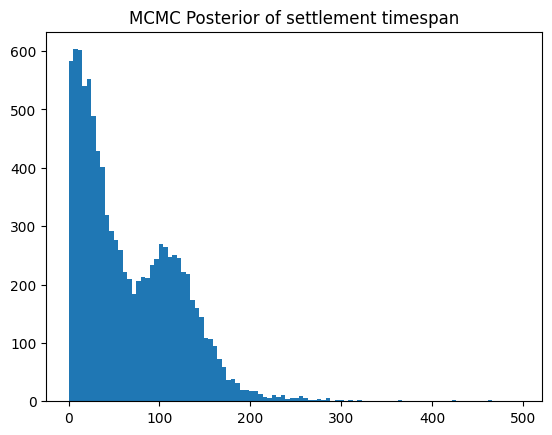

In [11]:
#timespan posterior
plt.hist(mcmc_shrink[:,0],bins = 100)
plt.title("MCMC Posterior of settlement timespan")
plt.show()

# FMPE

In [10]:
#get configuration
Config = Configuration() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
x_dim = 7
theta_dim  = 9 # theta for each dim + 2 psi's
input_dim = x_dim + theta_dim + 1

#create prior sampler!
def prior(n):
    """Creates sample from all 9 thetas == obs theta's + psi's
    [psi_lower,psi_upper,thetas 1 ... 7]"""
    output = torch.zeros((n,9))
    span = torch.rand(n) * (U-L)
    for k in range(n):
        #psis
        output[k,0] = torch.rand(1) * (U-span[k]-L) + L 
        output[k,1] = output[k,0] + span[k]
        #thetas
        output[k,2:] = torch.rand(7) * span[k] + output[k,0]
    return output

#create likelihood sampler
def simulator(thetas):
    """Samples data given parameter values.
    Parameter values take to be whole thetas in original form
    """
    idx = thetas[:,2:].int() - 1
    sig = np.sqrt(d**2 + err[idx]**2)
    return (torch.randn(idx.shape) * sig + mu[idx]).to(torch.float32)


In [13]:
#create dataset
n = Config.Dataset["n"]
tr_ind, val_ind = random_split(range(n), [0.98,0.02])
dataset = SbiDataset(prior,simulator,n) #[theta,x]
tr_dataloader = DataLoader(dataset[tr_ind],batch_size=Config.Train["batch"],shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(dataset[val_ind],batch_size=Config.Train["batch"],shuffle=False, num_workers=0, drop_last=True)
print(f"Epoch is {len(tr_dataloader)} batches, \nValidation is over {len(val_dataloader)} batches")


Epoch is 3062 batches, 
Validation is over 62 batches


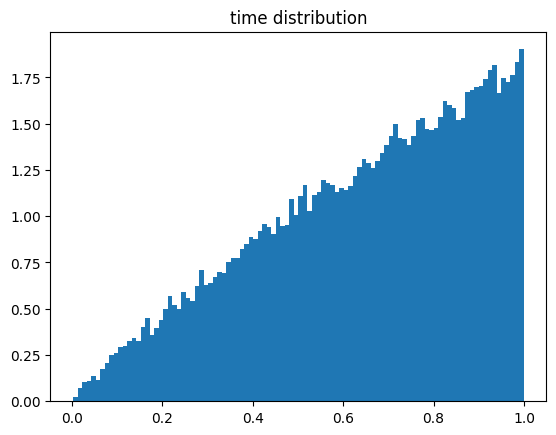

In [14]:
#create FMPE objective
if Config.FM["t_dist"] == "power_law":
    tdist = partial(power_law_, alpha = Config.FM["alpha"])
else:
    tdist = time_uniform

plt.hist(tdist(50000), bins = 100, density=True)
plt.title("time distribution")
plt.show()

FM = partial(FM_, sigma_min = Config.FM["sigma_min"], batch = Config.Train["batch"],device = device, t_dist = tdist)

In [15]:
#initialize FM,NN,Optimizer,Diagnostics
model = MLP_FMPE(input_dim=input_dim, output_dim=theta_dim, **Config.NN) #TODO: Specify intput & output dim!

@torch.no_grad()
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight) 
model.apply(init_weights)
model.to(device)
print(f"The NN has {sum([p.nelement() for p in model.parameters()])} parameters")

optimizer = torch.optim.Adam(model.parameters(), **Config.Optimizer)
Diag = Diagnostics()

The NN has 539145 parameters


In [34]:
#Training Loop
for epoch in tqdm(range(Config.Train["epochs"])):
    model.train()
    for theta_and_x in tr_dataloader: 
        # theta = theta_and_x[:,:theta_dim]
        # x = theta_and_x[:,theta_dim:]
        
        #forward pass
        input, ut = FM(theta_and_x[:,:theta_dim]) #input is [theta_t, t]
        full_input = torch.cat([theta_and_x[:,theta_dim:],input], dim = -1).to(device) #[x,theta_t,t]
        vt = model(full_input)
        loss = mse_loss(vt,ut) 

        #backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()                #gradient update
        Diag.losses.append(loss.item()) #stats

    model.eval()
    Diag.epoch_tr_loss.append(np.mean(Diag.losses[-len(tr_dataloader):]))
    with torch.no_grad():
        #loss
        val_loss = 0
        for theta_and_x in val_dataloader:
            input, ut = FM(theta_and_x[:,:theta_dim])
            full_input = torch.cat([theta_and_x[:,theta_dim:],input], dim = -1).to(device) #[x,eta_t,t]
            vt = model(full_input)
            val_loss += mse_loss(vt,ut)
        val_loss /= len(val_dataloader)
        Diag.epoch_val_loss.append(val_loss)




100%|██████████| 50/50 [14:23<00:00, 17.28s/it]


# Diagnostics & Plots

In [23]:
# #epoch losses
# epochloss_ = plot_epochloss(**asdict(Diag))
# epochloss_.ylim(0,0.4) 
# epochloss_.show()


#trajectories
obs = dataset.standardize(torch.tensor(y, dtype = torch.float32),label="x") #[1,x_dim]
target = mcmc_shrink[:,1:10] #[10000,theta_dim]
source_sample = torch.randn(10000,theta_dim) #[n,theta_dim]


model.eval()
node = NeuralODE(torch_wrapper_FMPE(model, obs = obs), solver="dopri5", sensitivity="adjoint", atol=1e-5, rtol=1e-5)
with torch.no_grad():
    traj = node.trajectory(source_sample, t_span = torch.linspace(0,1,101)) #[T,n,theta_dim]
    #plot_trajectories(dataset.standardize(traj.cpu().numpy(),label="theta",inverse=True)[:,:,:2], target = target[:,:2], box=[[400,1000],[400,1000]])


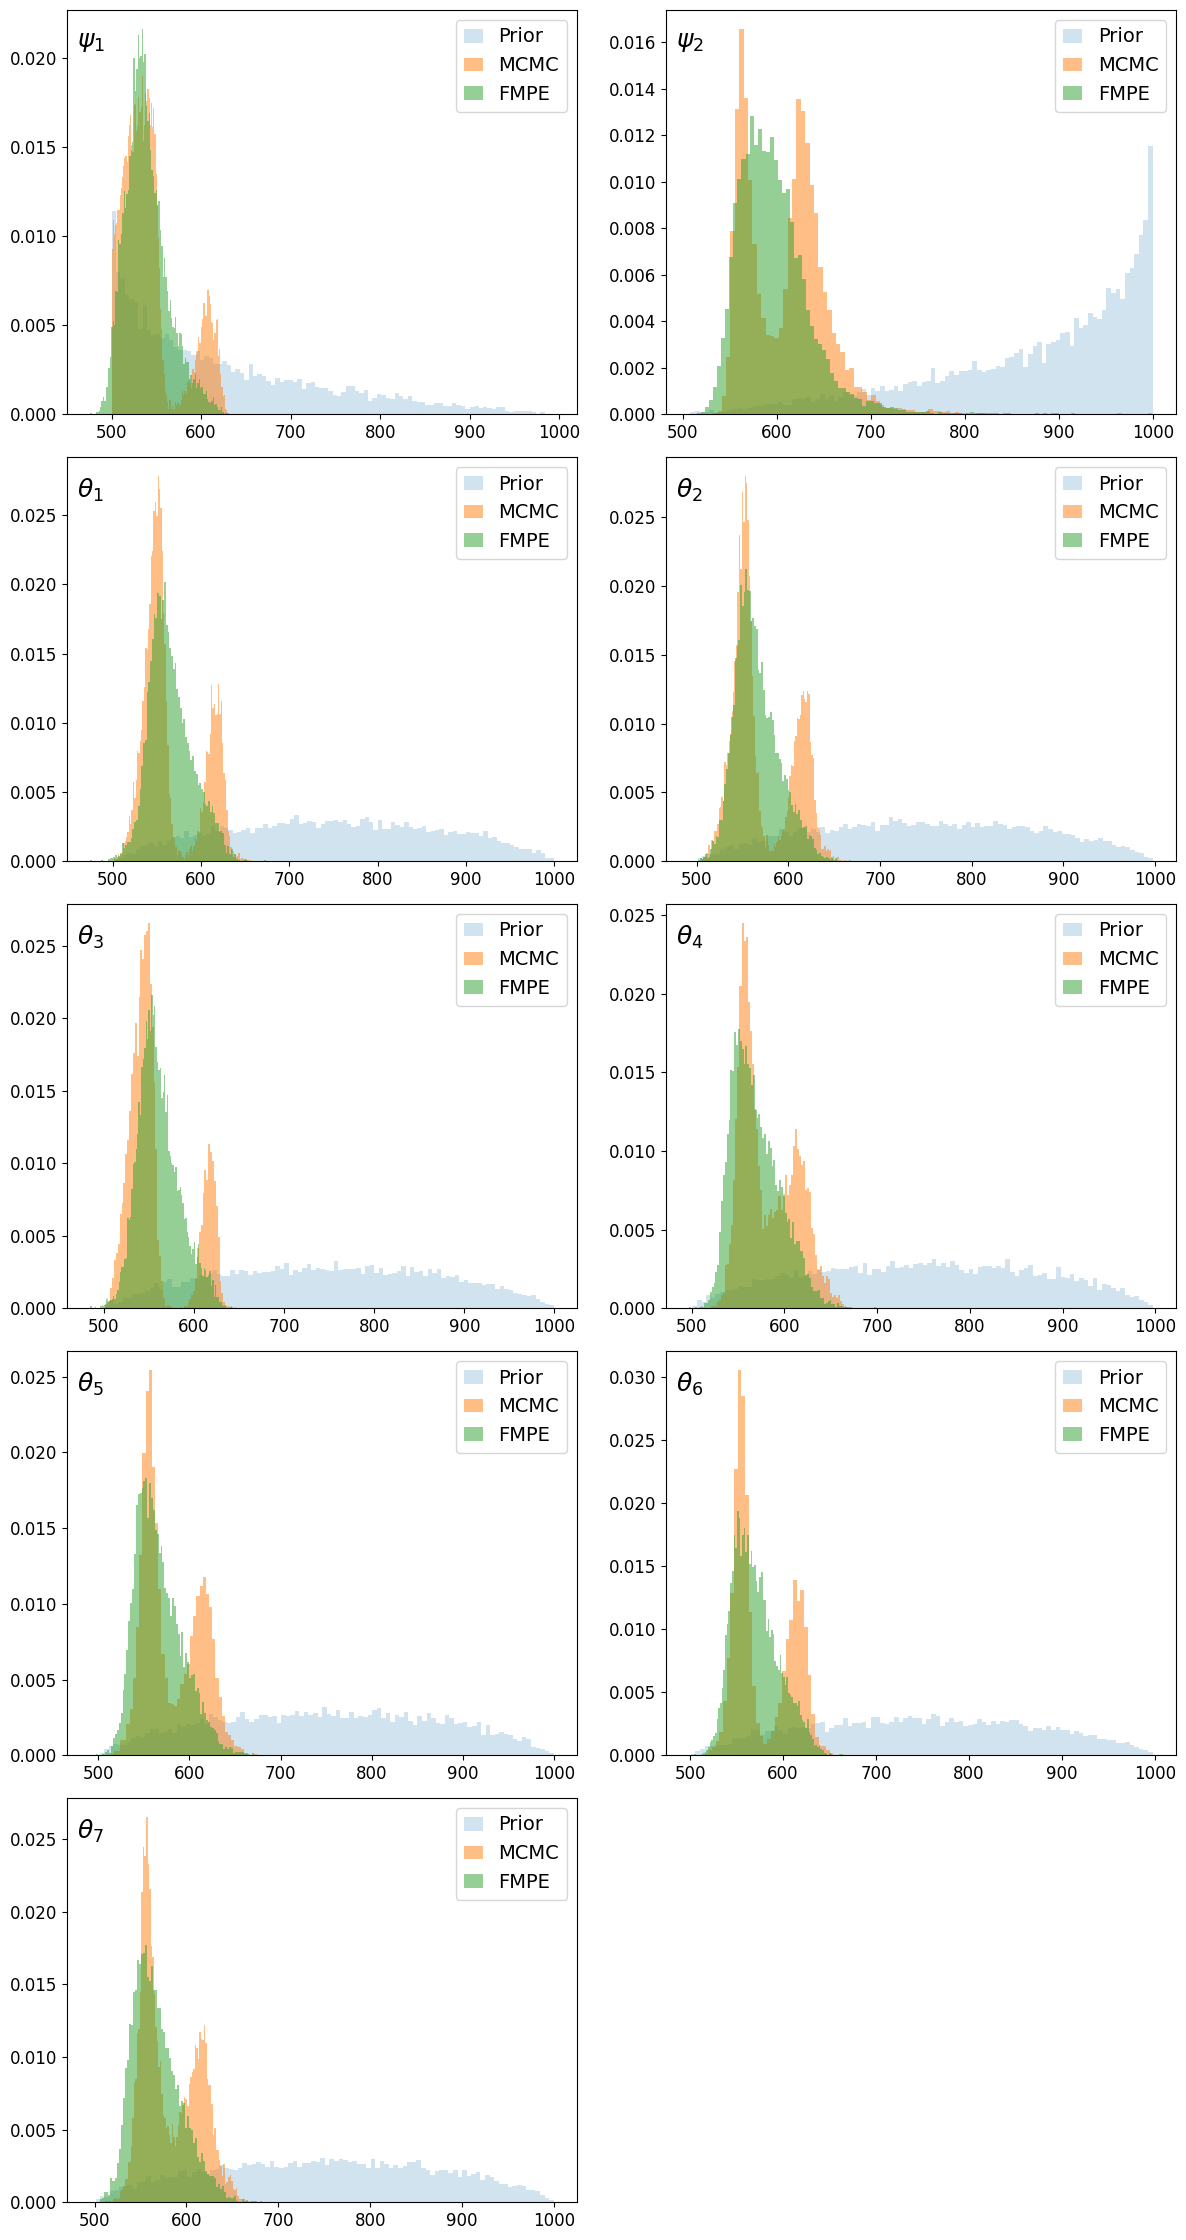

In [26]:
prior_sample = prior(10000)
colnames_plot = [r"$\psi_1$",r"$\psi_2$"] + [r"$\theta_" + str(i) + "$" for i in range(1,8)]

default_colors = plt.cm.tab10.colors  
fig, ax = plt.subplots(theta_dim//2 + 1, 2, figsize=(6*2, 5/2*theta_dim))
ax = ax.flatten()
for dim in range(theta_dim):
    ax[dim].hist(prior_sample[:,dim], bins = 100, label = "Prior", alpha = 0.2, density = True, color = default_colors[0])
    ax[dim].hist(target[:,dim], bins = 100, label = "MCMC", alpha = 0.5, density = True, color = default_colors[1]) #mcmc is col[3] but here represents target [1]
    ax[dim].hist(dataset.standardize(traj.cpu().numpy(),label="theta",inverse=True)[-1,:,dim], bins = 100, label = "FMPE",alpha = 0.5, density = True, color = default_colors[2])
    ax[dim].text(0.02, 0.95, colnames_plot[dim], transform=ax[dim].transAxes, 
                 fontsize=18, verticalalignment='top', horizontalalignment='left')
    ax[dim].legend(handlelength = 1,fontsize = 14, loc = "upper right")
    ax[dim].tick_params(axis='both', which='major', labelsize=12)

ax[-1].axis('off')
plt.tight_layout()


# plt.savefig('plots/RCD_HIST_BIG.svg', format='svg', dpi=300)
# plt.savefig('plots/RCD_HIST_BIG.png', dpi=300)  # PNG with high DPI


plt.show()

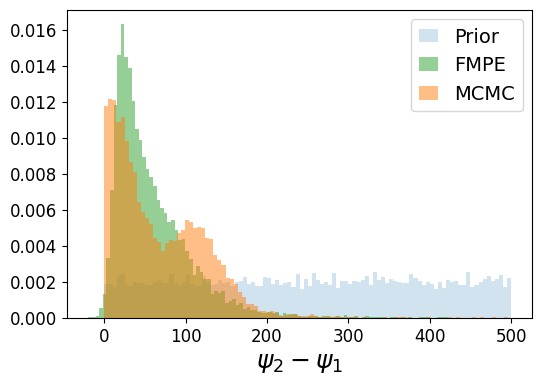

In [27]:
aaa = dataset.standardize(traj.cpu().numpy(),label="theta",inverse=True)[-1,:,:]
span_fmpe = aaa[:,1] - aaa[:,0]
span_mcmc = mcmc_shrink[:,0]
span_prior = prior_sample[:,1] - prior_sample[:,0]

plt.figure(figsize = (6,4))
plt.hist(span_prior,bins = 100, label = "Prior", alpha = 0.2, density = True, color = default_colors[0])
plt.hist(span_fmpe,bins = 100, label = "FMPE", alpha = 0.5, density = True, color = default_colors[2])
plt.hist(mcmc_shrink[:,0],bins = 100, label = "MCMC", alpha = 0.5, density = True, color = default_colors[1])
plt.xlabel(r"$\psi_2 - \psi_1$", fontsize = 18)
plt.legend(handlelength = 1,fontsize = 14, loc = "upper right")
plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig(f'plots/RCD_HIST_span_BIG.svg', format='svg', dpi=300)
# plt.savefig(f'plots/RCD_HIST_span_BIG.png', dpi=300)  # PNG with high DPI


plt.show()



In [28]:
# Dax Figure 4 --- C2ST score
# - scales at least quadratic with sample size!

AA = torch.tensor(target, dtype = torch.float32)[:1000,:]
BB = torch.tensor(dataset.standardize(traj.cpu().numpy(),label="theta",inverse=True)[-1,:1000,:])

c2st_accuracy_fmpe_vs_mcmc = c2st(AA, BB)
print(c2st_accuracy_fmpe_vs_mcmc)

tensor([0.8030])


In [22]:
# #save or load model

# #save
# torch.save(model, "models/radiocarbon_BIG.pth")

# #load
# model = torch.load('models/radiocarbon_BIG.pth')

C:\Users\HP\AppData\Local\Temp\ipykernel_9908\80274329.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/radiocarbon_BIG_1.pth')
